In [1]:
!pip install fastai --upgrade

     |████████████████████████████████| 194kB 5.9MB/s 
     |████████████████████████████████| 61kB 7.1MB/s 
  Found existing installation: fastai 1.0.61
    Uninstalling fastai-1.0.61:
      Successfully uninstalled fastai-1.0.61


In [2]:
!git clone https://github.com/rwightman/pytorch-image-models/

Cloning into 'pytorch-image-models'...
remote: Enumerating objects: 17, done.
remote: Counting objects: 100% (17/17), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 4589 (delta 1), reused 10 (delta 0), pack-reused 4572
Receiving objects: 100% (4589/4589), 15.78 MiB | 9.58 MiB/s, done.
Resolving deltas: 100% (3299/3299), done.


In [3]:
%cd pytorch-image-models

/content/pytorch-image-models


In [4]:
!wget https://www.dropbox.com/s/cb3g53z4pbtaqvl/erm.zip?dl=1 -O erm.zip

--2021-03-01 07:21:59--  https://www.dropbox.com/s/cb3g53z4pbtaqvl/erm.zip?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.80.18, 2620:100:6032:18::a27d:5212
Connecting to www.dropbox.com (www.dropbox.com)|162.125.80.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/dl/cb3g53z4pbtaqvl/erm.zip [following]
--2021-03-01 07:21:59--  https://www.dropbox.com/s/dl/cb3g53z4pbtaqvl/erm.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucc6998a5deafff96a29c989dfb9.dl.dropboxusercontent.com/cd/0/get/BJ0cEn43tMcpGY9ZUD2q34P60FvNfr3yl9-cSaGn-bznf4HtoUPwVV2STgrr81Ho4WJf05MHuYKls7TzQgQeizkC9LlIgyfzzg5XHd8DyFpYfINj_xSHg5FaaDtzNWGr72g/file?dl=1# [following]
--2021-03-01 07:21:59--  https://ucc6998a5deafff96a29c989dfb9.dl.dropboxusercontent.com/cd/0/get/BJ0cEn43tMcpGY9ZUD2q34P60FvNfr3yl9-cSaGn-bznf4HtoUPwVV2STgrr81Ho4WJf05MHuYKls7TzQgQeizkC9LlIgyfzzg5XHd8DyFpYfINj_xSHg5Faa

In [5]:
!unzip erm.zip

Archive:  erm.zip
   creating: dataset/
   creating: dataset/test/
   creating: dataset/test/no/
  inflating: dataset/test/no/anonymized_1421704.jpg  
  inflating: dataset/test/no/anonymized_336537.jpg  
  inflating: dataset/test/no/anonymized_569526.jpg  
  inflating: dataset/test/no/anonymized_196860.jpg  
  inflating: dataset/test/no/anonymized_920184.jpg  
  inflating: dataset/test/no/anonymized_1348815.jpg  
  inflating: dataset/test/no/anonymized_225304.jpg  
  inflating: dataset/test/no/anonymized_816099.jpg  
  inflating: dataset/test/no/anonymized_260226.jpg  
  inflating: dataset/test/no/anonymized_1619231.jpg  
  inflating: dataset/test/no/anonymized_1314755.jpg  
  inflating: dataset/test/no/anonymized_1182585.jpg  
  inflating: dataset/test/no/anonymized_656024.jpg  
  inflating: dataset/test/no/anonymized_198917.jpg  
  inflating: dataset/test/no/anonymized_246204.jpg  
  inflating: dataset/test/no/anonymized_324557.jpg  
  inflating: dataset/test/no/anonymized_492637.jpg

In [6]:
from fastai.vision.all import *
import fastai

In [7]:
path = Path('dataset/')
trainPath = path/'train'
testPath = path/'test'

In [8]:
def getDataBlock(presize=512,size=384):
    return DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=RandomSplitter(valid_pct=0.2,seed=42),
                 get_y=parent_label,
                 item_tfms = Resize(presize),
                 batch_tfms=[*aug_transforms(size=size, min_scale=0.75), Normalize.from_stats(*imagenet_stats)])

In [9]:
db512 = getDataBlock()
dls512 = db512.dataloaders(trainPath,bs=16)

In [14]:
from fastai.vision.all import *
callbacks = [
    ShowGraphCallback(),
    EarlyStoppingCallback(patience=3),
    SaveModelCallback(fname='deit384'),

    ReduceLROnPlateau(patience=1)
]

In [15]:
import timm

In [16]:
learn = Learner(dls512,timm.models.vision_transformer.vit_deit_base_patch16_384(num_classes=2,pretrained=True),metrics=accuracy,cbs=callbacks)

SuggestedLRs(lr_min=8.31763736641733e-07, lr_steep=0.17378008365631104)

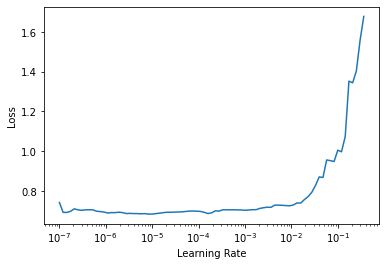

In [ ]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time
0,0.651522,0.640504,0.628440,02:53


Better model found at epoch 0 with valid_loss value: 0.6405044198036194.


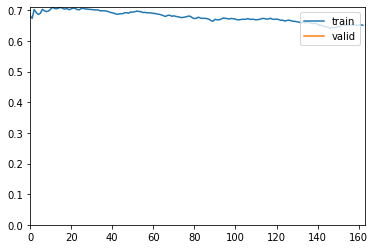

epoch,train_loss,valid_loss,accuracy,time
0,0.542998,0.533708,0.726300,02:53
1,0.484055,0.519696,0.750765,02:53
2,0.476302,0.513435,0.749235,02:53
3,0.479799,0.506770,0.762997,02:53
4,0.451861,0.535548,0.746177,02:53
5,0.422964,0.549365,0.720183,02:53
6,0.390659,0.531446,0.738532,02:53


Better model found at epoch 0 with valid_loss value: 0.533708393573761.


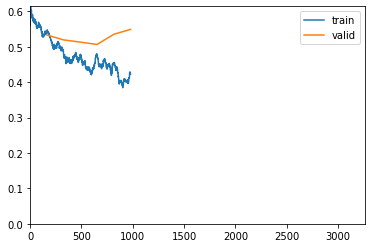

Better model found at epoch 1 with valid_loss value: 0.5196964144706726.
Better model found at epoch 2 with valid_loss value: 0.5134353637695312.
Better model found at epoch 3 with valid_loss value: 0.506770133972168.
Epoch 4: reducing lr to 4.728829479707258e-06
Epoch 5: reducing lr to 4.999989680918921e-06
No improvement since epoch 3: early stopping


In [17]:
learn.fine_tune(20,base_lr=1e-4)

In [18]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=GrandparentSplitter(valid_name='test'),
                 get_y=parent_label,
                 item_tfms = Resize(512),
                 batch_tfms=[*aug_transforms(size=384, min_scale=0.75), Normalize.from_stats(*imagenet_stats)])
dlsTest = dbTest.dataloaders(path,bs=32)

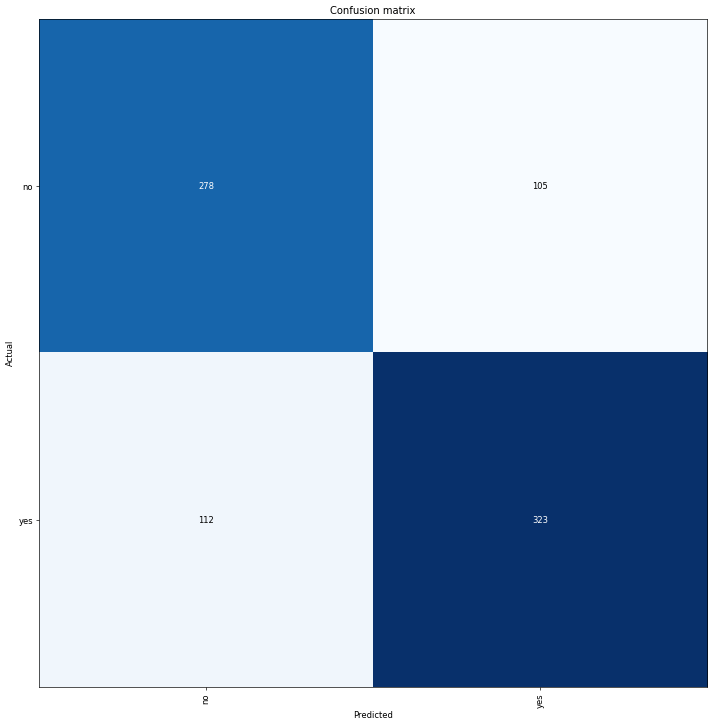

In [19]:
learn.dls = dlsTest
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12),dpi=60)

In [20]:
learn.metrics=[accuracy,Precision(),Recall()]

In [21]:
learn.validate()

Better model found at epoch 0 with valid_loss value: 0.7347187995910645.


(#4) [0.5059366226196289,0.7347187995910645,0.7546728971962616,0.7425287356321839]

In [ ]:
[0.5496695041656494,0.7127139568328857,0.7840909090909091,0.6344827586206897]